#Package Installation

P.S: The sam2 installation might seems like it hanged but it is ongoing, do not try to see the details using verbose -v, its like a million lines long and the colab env starts to hang a little

In [ ]:
!pip3 install torch torchvision torchaudio
!mkdir grounding
%cd grounding
!git clone https://github.com/IDEA-Research/GroundingDINO.git

%cd /content/grounding/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn
!sed -i 's/value.type()/value.scalar_type()/g' ms_deform_attn_cuda.cu
!sed -i 's/value.scalar_type().is_cuda()/value.is_cuda()/g' ms_deform_attn_cuda.cu

%cd /content/grounding/GroundingDINO
!pip install -e .
%cd ..
%cd ..

!mkdir sam_2
%cd sam_2
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace

%cd ..
%cd ..

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_base_plus.pt
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

mkdir: cannot create directory ‘grounding’: File exists
/content/grounding
fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/content/grounding/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn
/content/grounding/GroundingDINO
Obtaining file:///content/grounding/GroundingDINO
  Preparing metadata (setup.py) ... done
  Attempting uninstall: groundingdino
    Found existing installation: groundingdino 0.1.0
    Uninstalling groundingdino-0.1.0:
      Successfully uninstalled groundingdino-0.1.0
  Running setup.py develop for groundingdino
/content/grounding
/content
mkdir: cannot create directory ‘sam_2’: File exists
/content/sam_2
fatal: destination path 'segment-anything-2' already exists and is not an empty directory.
/content/sam_2/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (p

In [ ]:
!pip install -q supervision jupyter_bbox_widget

##Adding to path

In [ ]:
import sys
sys.path.append("/content/sam_2/segment-anything-2/")
sys.path.append("/content/grounding/GroundingDINO/")

##Import Libraries

In [ ]:
import torch
import cv2
import numpy as np
import base64
import matplotlib.pyplot as plt
from pathlib import Path
from groundingdino.util.inference import load_model, load_image, predict, annotate
from sam2.build_sam import build_sam2,build_sam2_video_predictor
from sam2.sam2_image_predictor import SAM2ImagePredictor
from torchvision.ops import box_convert
from PIL import Image
import os
import supervision as sv
from supervision.assets import download_assets, VideoAssets
from google.colab import output
output.enable_custom_widget_manager()
from jupyter_bbox_widget import BBoxWidget

##Load Image for grounding dino

In [ ]:
image_path = "example_image.jpg"
image_source, image = load_image(image_path)


##Converting to Region Seeds and generating Boxes using GroundingDINO

final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


Detected phrases: ['dog']


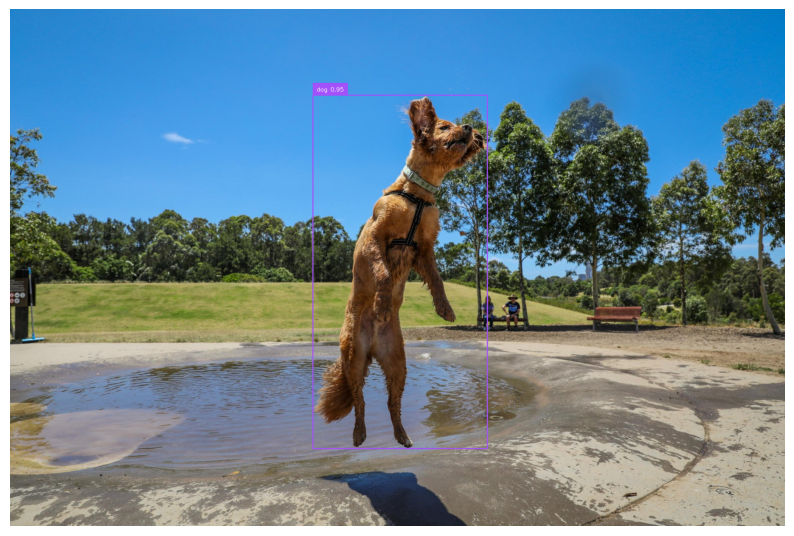

True

In [ ]:
text_prompt = "dog"
dino_model = load_model("/content/grounding/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "/content/groundingdino_swint_ogc.pth")
boxes, logits, phrases = predict(dino_model, image, text_prompt, box_threshold=0.3, text_threshold=0.25)

print("Detected phrases:", phrases)
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

cv2.imwrite("annotated_image.jpg", annotated_frame)


##Converting Boxes to SAM2 format (xyxy)

In [ ]:
h, w, _ = image_source.shape
boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
input_box = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()

##Loading image for SAM2

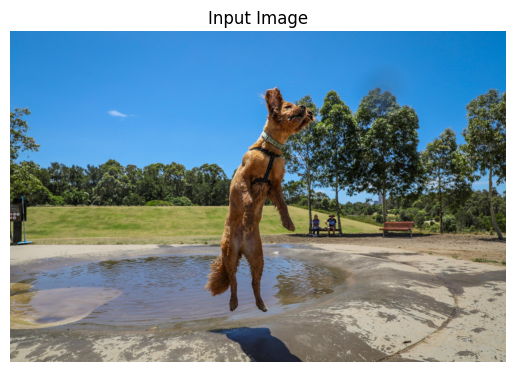

In [ ]:
image = Image.open(image_path)
image = np.array(image.convert("RGB"))
plt.imshow(image)
plt.title("Input Image")
plt.axis("off")
plt.show()

##Feeding Seeds to SAM2

In [ ]:
sam2_model = build_sam2("/configs/sam2.1/sam2.1_hiera_s.yaml","sam2.1_hiera_small.pt")
predictor = SAM2ImagePredictor(sam2_model)

predictor.set_image(image)


masks, scores, logits = predictor.predict(point_coords=None,point_labels=None,box=input_box,multimask_output=False)

##Generating Overlay Mask

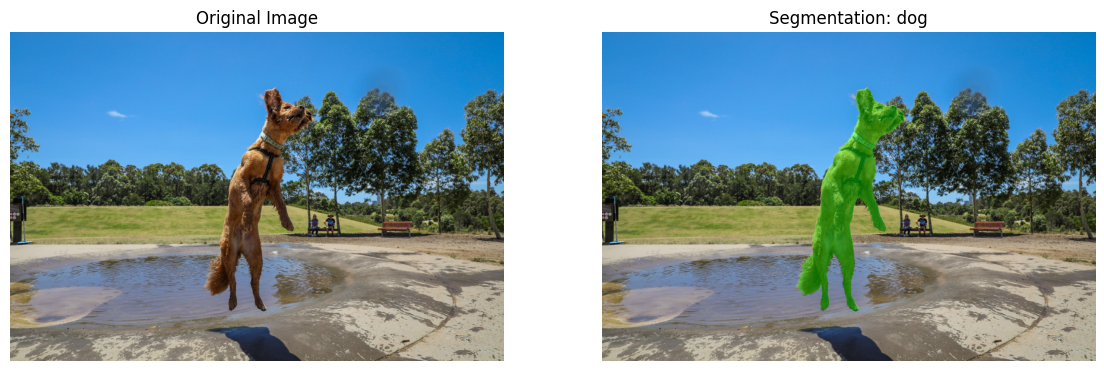

In [ ]:
mask = masks[0].astype(bool)
overlay = image.copy()
alpha = 0.4
overlay[mask] = (overlay[mask] * (1 - alpha) + np.array([0, 255, 0]) * alpha).astype(np.uint8)
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title(f"Segmentation: {phrases[0]}")
plt.axis("off")
plt.show()

#Video Masking using SAM2 with manual object selection using BBOX widget

##Change SOURCE_VIDEO to any video file as needed

SCALE_FACTOR reduces the resolution of the image to reduce the requirement of VRAM

START_IDX and END_IDX are frame ranges to extract from the video

In [ ]:
SOURCE_VIDEO = "example_video.mp4"
sv.VideoInfo.from_video_path(SOURCE_VIDEO)

SCALE_FACTOR = 0.5
START_IDX = 0
END_IDX = 300

In [ ]:
HOME = "/content"

##Splitting the Video into Frames since SAM2 Assumes that the video is in a corresponding format

In [ ]:
SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO, start=START_IDX, end=END_IDX)
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)

with images_sink:
    for frame in frames_generator:
        frame = sv.scale_image(frame, SCALE_FACTOR)
        images_sink.save_image(frame)

TARGET_VIDEO = Path(HOME) / f"{Path(SOURCE_VIDEO).stem}-result.mp4"
SOURCE_FRAME_PATHS = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))

##Function to read the frame images from the folder

In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

#Multi Objects

##Initialise the sam2 video predictor model with corresponding config and checkpoint

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/sam2.1_hiera_large.pt"
CONFIG = "/configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

In [ ]:
inference_state = sam2_model.init_state(video_path=SOURCE_FRAMES.as_posix())

frame loading (JPEG): 100%|██████████| 200/200 [00:08<00:00, 24.03it/s]


##Define the objects in the video to be segmented

In [ ]:
OBJECTS = ['dog','car']

In [ ]:
FRAME_IDX = 0
FRAME_PATH = Path(SOURCE_FRAMES) / f"{FRAME_IDX:05d}.jpeg"

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image(FRAME_PATH)
widget

BBoxWidget(classes=['dog', 'car'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '…

##Boxes are extracted form the BBOX and converted into points and labels with each object assigned a obj_id

##Selected points are addeed to the SAM2 video model to select the objects

In [ ]:
boxes = widget.bboxes
print(boxes)
for object_id, label in enumerate(OBJECTS, start=1):
    boxes = [box for box in widget.bboxes if box['label'] == label]

    if len(boxes) == 0:
        continue

    points = np.array([
        [
            box['x'],
            box['y']
        ] for box in boxes
    ], dtype=np.float32)
    labels = np.ones(len(points))

    _, object_ids, mask_logits = sam2_model.add_new_points(
        inference_state=inference_state,
        frame_idx=FRAME_IDX,
        obj_id=object_id,
        points=points,
        labels=labels,
    )

[{'x': 486, 'y': 354, 'width': 0, 'height': 0, 'label': 'dog'}, {'x': 472, 'y': 323, 'width': 0, 'height': 0, 'label': 'dog'}, {'x': 457, 'y': 286, 'width': 0, 'height': 0, 'label': 'dog'}, {'x': 441, 'y': 263, 'width': 0, 'height': 0, 'label': 'dog'}, {'x': 1104, 'y': 176, 'width': 0, 'height': 0, 'label': 'car'}, {'x': 1057, 'y': 199, 'width': 0, 'height': 0, 'label': 'car'}, {'x': 992, 'y': 183, 'width': 0, 'height': 0, 'label': 'car'}, {'x': 1067, 'y': 227, 'width': 0, 'height': 0, 'label': 'car'}]


##Propogation of the selected objects through the video

In [ ]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

COLORS = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700']
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    color_lookup=sv.ColorLookup.CLASS)

frame_sample = []

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame_path = SOURCE_FRAME_PATHS[frame_idx]
        frame = cv2.imread(frame_path)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            class_id=np.array(object_ids)
        )

        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)

        sink.write_frame(annotated_frame)
        if frame_idx % video_info.fps == 0:
            frame_sample.append(annotated_frame)

propagate in video: 100%|██████████| 200/200 [03:54<00:00,  1.17s/it]


##Sample frames from the video showing object segmentation

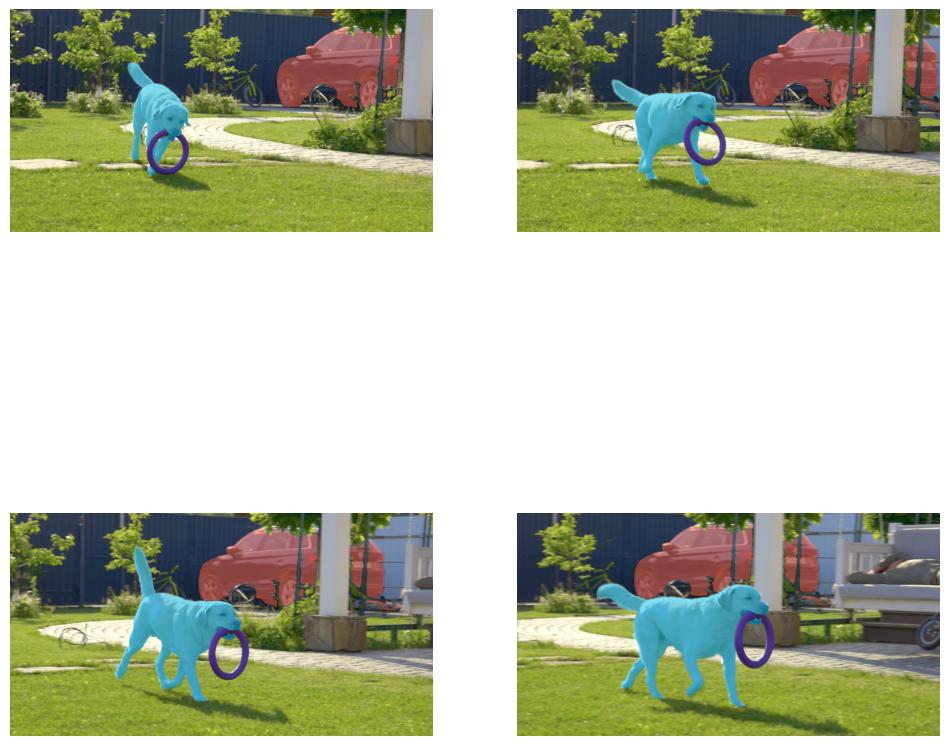

In [ ]:
sv.plot_images_grid(
    images=frame_sample[:4],
    grid_size=(2, 2)
)

##Single Objects

##Similar to the Multi Objects Segmentation

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/sam2.1_hiera_large.pt"
CONFIG = "/configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

In [ ]:
sam2_model.reset_state(inference_state)

In [ ]:
inference_state = sam2_model.init_state(video_path=SOURCE_FRAMES.as_posix())

frame loading (JPEG): 100%|██████████| 200/200 [00:08<00:00, 24.01it/s]


##Objects array only has a singular class

In [ ]:
OBJECTS = ['dog']

In [ ]:
FRAME_IDX = 0
FRAME_PATH = Path(SOURCE_FRAMES) / f"{FRAME_IDX:05d}.jpeg"

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image(FRAME_PATH)
widget

BBoxWidget(classes=['dog'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2…

In [ ]:
boxes = widget.bboxes
print(boxes)
for object_id, label in enumerate(OBJECTS, start=1):
    boxes = [box for box in widget.bboxes if box['label'] == label]

    if len(boxes) == 0:
        continue

    points = np.array([
        [
            box['x'],
            box['y']
        ] for box in boxes
    ], dtype=np.float32)
    labels = np.ones(len(points))

    _, object_ids, mask_logits = sam2_model.add_new_points(
        inference_state=inference_state,
        frame_idx=FRAME_IDX,
        obj_id=object_id,
        points=points,
        labels=labels,
    )

[{'x': 440, 'y': 260, 'width': 0, 'height': 0, 'label': 'dog'}, {'x': 461, 'y': 277, 'width': 0, 'height': 0, 'label': 'dog'}, {'x': 473, 'y': 300, 'width': 0, 'height': 0, 'label': 'dog'}, {'x': 489, 'y': 327, 'width': 0, 'height': 0, 'label': 'dog'}]


##Masks has to be reshaped to account for the reduction in channels

In multi-object segmentations, masks take the form of (N,H,W) where N is the number of objects

while in Single-Object segmentation, masks revert to the form of (H,W) since number of objects is 1

hence it has to be reshaped to (1,masks.shape[0],masks.shape[1])

A streamlined way of calculating the number of classes based on the len of the OBJECTS array can also be implemented if needed.

the reshaping of the masks can be assigned (m,masks.shape[0],masks.shape[1]), where m is the length of the objects array

In [ ]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

COLORS = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700']
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    color_lookup=sv.ColorLookup.CLASS)

frame_sample = []

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame_path = SOURCE_FRAME_PATHS[frame_idx]
        frame = cv2.imread(frame_path)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)
        masks = masks.reshape(1, masks.shape[0], masks.shape[1])

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            class_id=np.array(object_ids)
        )

        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)

        sink.write_frame(annotated_frame)
        if frame_idx % video_info.fps == 0:
            frame_sample.append(annotated_frame)

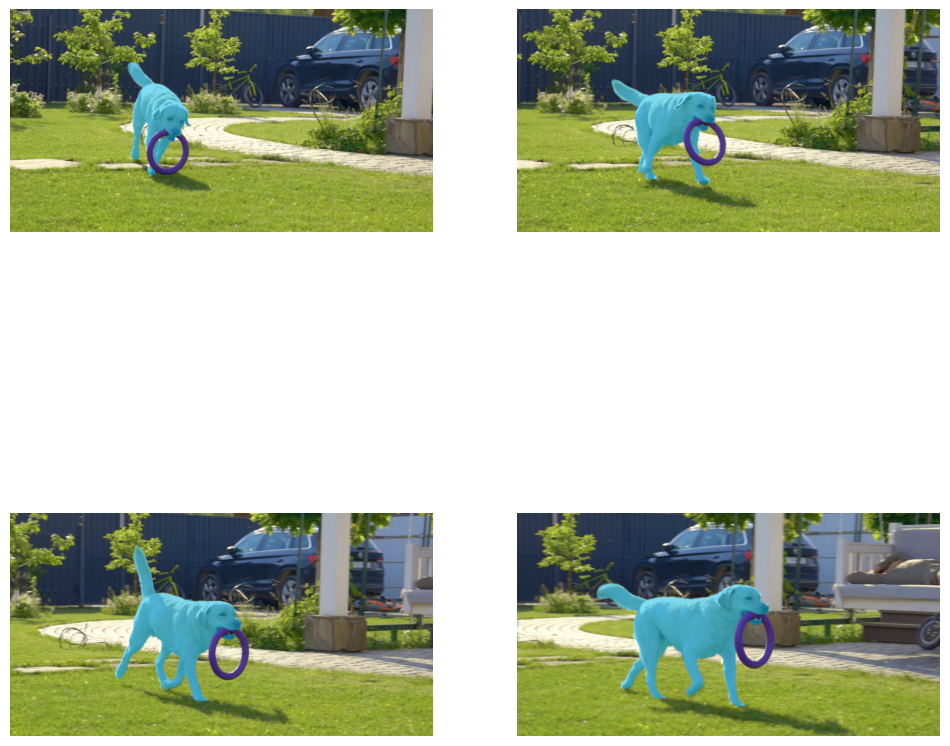

In [ ]:
sv.plot_images_grid(
    images=frame_sample[:4],
    grid_size=(2, 2)
)

#Video Masking using SAM2 with GroundingDINO text prompt

##Prompt-dog

Load an image from the frames folder

In [ ]:
image_path = Path(SOURCE_VIDEO).stem+"/00000.jpeg"
image_source, image = load_image(image_path)

Run the GroundingDino model along with the text_prompt to generate the corresponding bounding boxes

final text_encoder_type: bert-base-uncased


Detected phrases: ['dog']


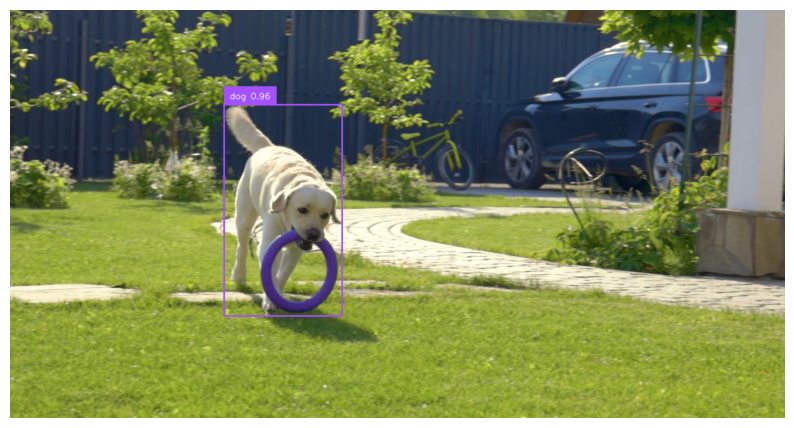

In [ ]:
text_prompt = "dog"
dino_model = load_model("/content/grounding/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "/content/groundingdino_swint_ogc.pth")
boxes, logits, phrases = predict(dino_model, image, text_prompt, box_threshold=0.3, text_threshold=0.25)

print("Detected phrases:", phrases)
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


Convert the boxes into xyxy format to be fed to SAM2 models

In [ ]:
h, w, _ = image_source.shape
boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
input_box = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()

Similar to previous methods

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/sam2.1_hiera_large.pt"
CONFIG = "/configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

In [ ]:
sam2_model.reset_state(inference_state)

In [ ]:
inference_state = sam2_model.init_state(video_path=SOURCE_FRAMES.as_posix())

frame loading (JPEG): 100%|██████████| 200/200 [00:08<00:00, 24.43it/s]


In [ ]:
sam2_model.add_new_points_or_box(inference_state=inference_state,
    frame_idx=0,
    obj_id=1,
    box=input_box[0]
)

(0,
 [1],
 tensor([[[[-24.2474, -24.2474, -24.2474,  ..., -27.0168, -27.0168, -27.0168],
           [-24.2956, -24.2956, -24.2956,  ..., -26.8290, -26.8290, -26.8290],
           [-24.8096, -24.8096, -24.8096,  ..., -24.8254, -24.8254, -24.8254],
           ...,
           [-26.6200, -26.6200, -26.6200,  ..., -24.4984, -24.4984, -24.4984],
           [-24.5441, -24.5441, -24.5441,  ..., -24.3573, -24.3573, -24.3573],
           [-24.3495, -24.3495, -24.3495,  ..., -24.3441, -24.3441, -24.3441]]]],
        device='cuda:0'))

Same issue with multi/single object segmentation arises where the masks have to be reshaped

In [ ]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

COLORS = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700']
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    color_lookup=sv.ColorLookup.CLASS)

frame_sample = []

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame_path = SOURCE_FRAME_PATHS[frame_idx]
        frame = cv2.imread(frame_path)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)
        masks = masks.reshape(1, masks.shape[0], masks.shape[1])

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            class_id=np.array(object_ids)
        )

        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)

        sink.write_frame(annotated_frame)
        if frame_idx % video_info.fps == 0:
            frame_sample.append(annotated_frame)

propagate in video: 100%|██████████| 200/200 [03:00<00:00,  1.11it/s]


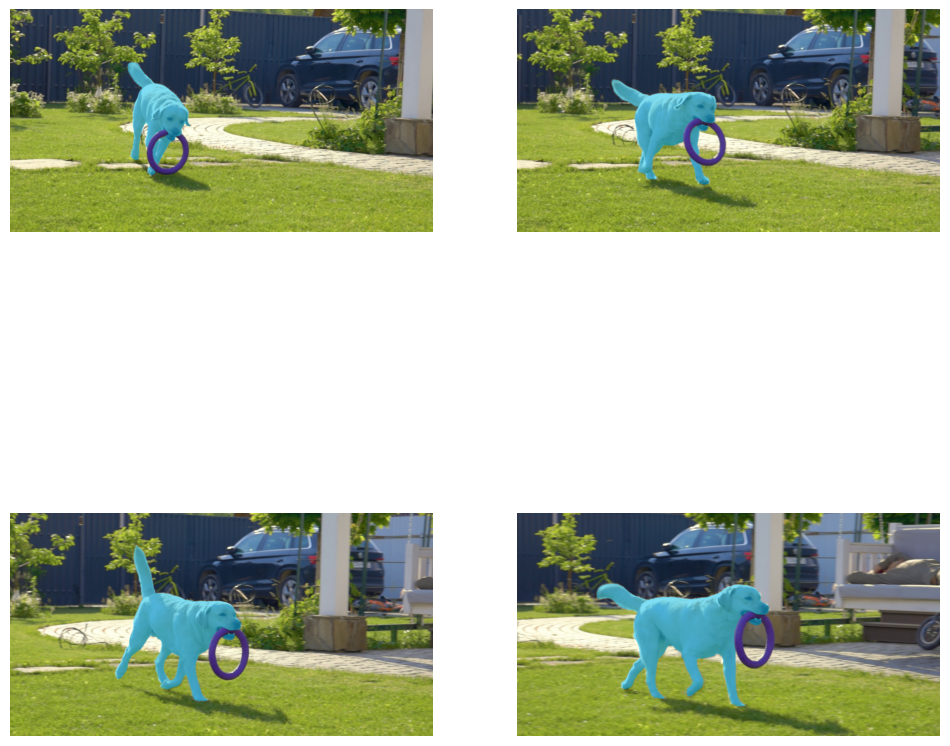

In [ ]:
sv.plot_images_grid(
    images=frame_sample[:4],
    grid_size=(2, 2)
)

##Prompt-car

In [ ]:
image_path = Path(SOURCE_VIDEO).stem+"/00000.jpeg"
image_source, image = load_image(image_path)

final text_encoder_type: bert-base-uncased


Detected phrases: ['car']


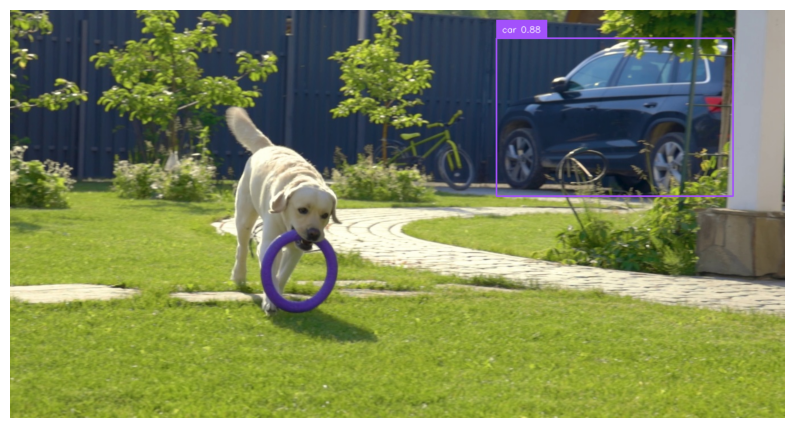

In [ ]:
text_prompt = "car"
dino_model = load_model("/content/grounding/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "/content/groundingdino_swint_ogc.pth")
boxes, logits, phrases = predict(dino_model, image, text_prompt, box_threshold=0.3, text_threshold=0.25)

print("Detected phrases:", phrases)
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [ ]:
h, w, _ = image_source.shape
boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
input_box = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/sam2.1_hiera_large.pt"
CONFIG = "/configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

In [ ]:
sam2_model.reset_state(inference_state)

In [ ]:
inference_state = sam2_model.init_state(video_path=SOURCE_FRAMES.as_posix())

frame loading (JPEG): 100%|██████████| 200/200 [00:08<00:00, 23.22it/s]


In [ ]:
sam2_model.add_new_points_or_box(inference_state=inference_state,
    frame_idx=0,
    obj_id=1,
    box=input_box[0]
)

(0,
 [1],
 tensor([[[[-17.9055, -17.9055, -17.9055,  ..., -17.4325, -17.4325, -17.4325],
           [-17.9404, -17.9404, -17.9404,  ..., -17.2609, -17.2609, -17.2609],
           [-18.3122, -18.3122, -18.3122,  ..., -15.4296, -15.4296, -15.4296],
           ...,
           [-19.5032, -19.5032, -19.5032,  ..., -18.5571, -18.5571, -18.5571],
           [-17.9712, -17.9712, -17.9712,  ..., -18.7279, -18.7279, -18.7279],
           [-17.8276, -17.8276, -17.8276,  ..., -18.7439, -18.7439, -18.7439]]]],
        device='cuda:0'))

In [ ]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

COLORS = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700']
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    color_lookup=sv.ColorLookup.CLASS)

frame_sample = []

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame_path = SOURCE_FRAME_PATHS[frame_idx]
        frame = cv2.imread(frame_path)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)
        masks = masks.reshape(1, masks.shape[0], masks.shape[1])

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            class_id=np.array(object_ids)
        )

        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)

        sink.write_frame(annotated_frame)
        if frame_idx % video_info.fps == 0:
            frame_sample.append(annotated_frame)

propagate in video: 100%|██████████| 200/200 [03:00<00:00,  1.11it/s]


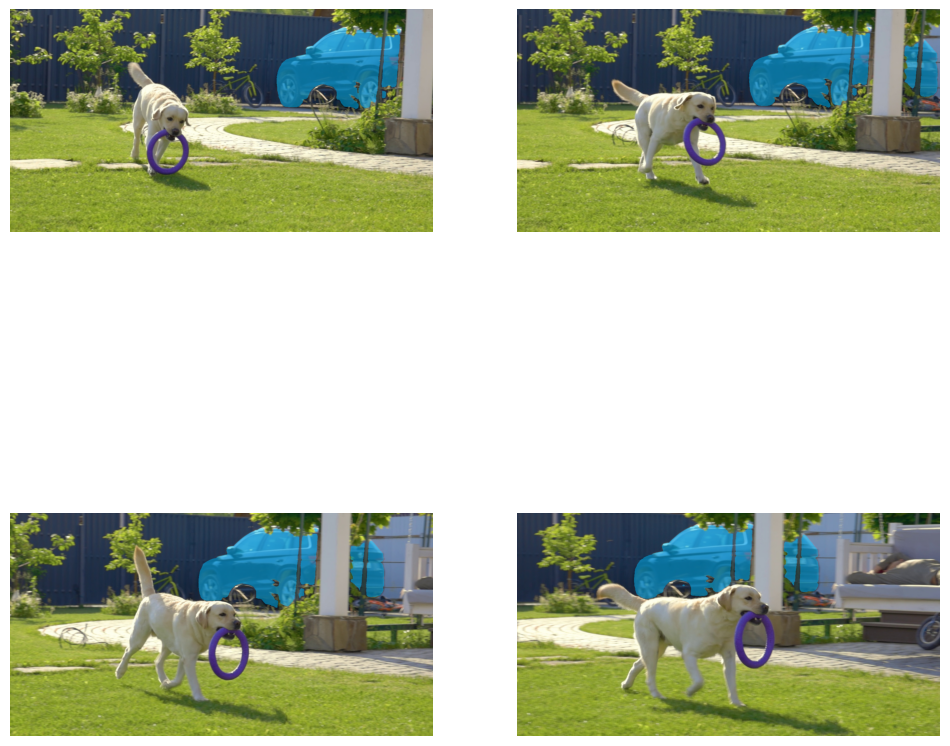

In [ ]:
sv.plot_images_grid(
    images=frame_sample[:4],
    grid_size=(2, 2)
)